# LAT Thermal Control & History Plots

### Robert Cameron (original author), September 2015
### Joe Eggen (refactoring & consolidation) - c. 2020 - 2023

The plots made by this notebook are to be used in the LAT Quarterly Trending Report. This notebook consolidates & streamlines the content of the notebooks LTC & LTC3 (VCHP Control History & Beta/Thermal/Distancs plots, respectively) that were formerly used for this purpose. Further improvements can undoubtedly be made. Please send improved notebooks or suggestions to Joe Eggen so that we can all benefit! It also helps greatly with version control.

In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
from os.path import expanduser
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import (MONTHLY, YEARLY, DateFormatter, rrulewrapper, RRuleLocator, drange)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from astropy.table import Table, Column
%matplotlib inline

In [2]:
# Define variables

##### This should be the only cell you need to make changes to! #####

Year_Qtr = "2022_Q4" # used to name output figures
HOME = expanduser("/Users/jeggen/ISOC/" + Year_Qtr)

# Plot axis bounds
dntmin="2008-01-01 00:00:00" # lower bound for plot x-axis
dntmax="2023-01-01 00:00:00" # upper bound for plot x-axis

dntminShort="2018-01-01 00:00:00" # lower bound of the zoomed-in plots x-axis

# You will need to get these files from either Rob or Joe's home directory at SLAC (under ~/LATmetrics/)
navfile = HOME+"/nav.history"
htrfile = HOME+"/htr.normall"
htrHistFile = HOME+"/htr.history"

# This file will be created & used later by this script
htrScatterFile = HOME+"/htr.scatter" 

# These are the name templates for the Beta/Conductance/Earth-Sun Distance plots
histFull = HOME+"/therm_history_"+Year_Qtr+"_full.png"
histShort = HOME+"/therm_history_"+Year_Qtr+"_zoom.png"

# These are the name templates for the VCHP Control plots
controlFull = HOME+"/VCHP_Control_"+Year_Qtr+"_full.png"
controlShort = HOME+"/VCHP_Control_"+Year_Qtr+"_zoom.png"

## Thermal Control History

In [3]:
# read regular ASCII tabular file of Fermi navigation history
navtab = Table.read(navfile, format='ascii',names=('ymd','hms','s1970','x','y','z','vx','vy','vz'))
ymd = navtab['ymd']
hms = navtab['hms']
s1970 = navtab['s1970']
x = navtab['x']
y = navtab['y']
z = navtab['z']
vx = navtab['vx']
vy = navtab['vy']
vz = navtab['vz']
d1970 = s1970/86400.0
JD = d1970 + 2440587.5
DJ2000 = JD - 2451545.0
yr = DJ2000/365.25 + 2000.0

In [4]:
# caculate beta angle from Fermi navigation history
# use Sun position calculations from http://aa.usno.navy.mil/faq/docs/SunApprox.php

g = np.radians(357.529 + 0.98560028 * DJ2000)    # g = mean anomaly of the Sun
q = 280.459 + 0.98564736 * DJ2000  # q = mean longitude of the Sun, in degrees
L = np.radians(q + 1.915 * np.sin(g) + 0.020 * np.sin(2*g)) # L = geocentric apparent ecliptic longitude of the Sun, adjusted for aberration
rAU = 1.00014 - 0.01671 * np.cos(g) - 0.00014 * np.cos(2*g)  # rAU = Sun-Earth distance in AU
e = np.radians(23.439 - 0.00000036 * DJ2000)  # e = mean obliquity of the ecliptic

# get Sun's RA and Dec
tanRA = np.cos(e) * np.tan(L)
Zsun = np.sin(e) * np.sin(L)
sun_Dec = np.arcsin(Zsun)
sun_RA = np.arctan(np.cos(e) * np.sin(L),np.cos(L))
Xsun = np.cos(sun_Dec) * np.cos(sun_RA)
Ysun = np.cos(sun_Dec) * np.sin(sun_RA)

# normalize the Fermi position and velocity vectors
pos = np.sqrt(x*x + y*y + z*z)
vel = np.sqrt(vx*vx + vy*vy + vz*vz)
xn = x/pos
yn = y/pos
zn = z/pos
vxn = vx/vel
vyn = vy/vel
vzn = vz/vel

# get the vector to the Fermi orbit pole from the cross product of the Fermi position and velocity vectors
Polex = yn*vzn - zn*vyn
Poley = zn*vxn - xn*vzn
Polez = xn*vyn - yn*vxn

# calculate angle between Sun Vector and Fermi orbit pole, using dot product
# NOTE: beta angle is the complement of the angle from the dot product, so use sin instead of cos
sinbeta = Xsun*Polex + Ysun*Poley + Zsun*Polez
beta = np.degrees(np.arcsin(sinbeta))

In [5]:
doyformat = "%j"
doy = [dt.datetime.strptime(ymd[i],"%Y-%m-%d").timetuple().tm_yday for i in range(len(ymd))]
dnt = [dt.datetime.strptime(ymd[i]+hms[i],"%Y-%m-%d%H:%M:%S") for i in range(len(ymd))]

In [6]:
# read irregular ASCII tabular file of history of VCHP control
df = pd.read_csv(htrfile, parse_dates=[0], delimiter="\t",header=None)

fx = df[0]

VCHP0 = 1-pd.Series.rolling(df[1],axis=0,window=20,win_type='boxcar',center=True).mean()
VCHP1 = 1-pd.Series.rolling(df[2],axis=0,window=20,win_type='boxcar',center=True).mean()
VCHP6 = 1-pd.Series.rolling(df[7],axis=0,window=20,win_type='boxcar',center=True).mean()
VCHP7 = 1-pd.Series.rolling(df[8],axis=0,window=20,win_type='boxcar',center=True).mean()

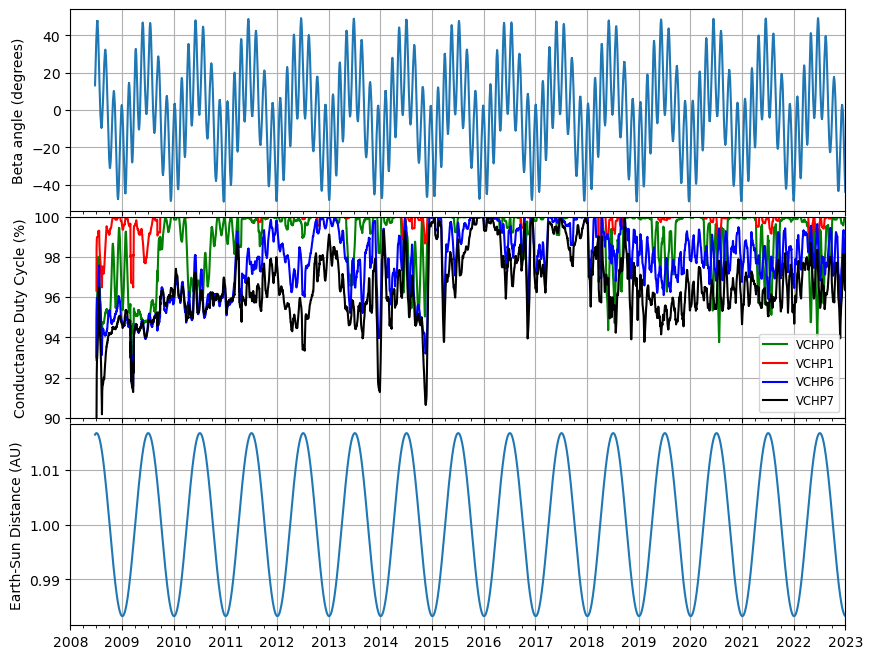

In [7]:
# 3 subplots for beta, VCHP, rAU, where the axes array is 1-d
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize = [10, 8])

dnt0 = dt.datetime.strptime(dntmin,"%Y-%m-%d %H:%M:%S")
dnt1 = dt.datetime.strptime(dntmax,"%Y-%m-%d %H:%M:%S")

yrule = rrulewrapper(YEARLY, interval=1)
yloc = RRuleLocator(yrule)
mrule = rrulewrapper(MONTHLY, interval=3)
mloc = RRuleLocator(mrule)

ax1.xaxis.set_major_locator(yloc)
ax3.xaxis.set_minor_locator(mloc)
ax1.plot(dnt, beta)
ax1.set_xlim(xmin=dnt0, xmax=dnt1)

ax1.grid(True)
ax1.set_ylabel('Beta angle (degrees)')

ax2.plot(fx,VCHP0*100,'-g',label='VCHP0')
ax2.plot(fx,VCHP1*100,'-r',label='VCHP1')
ax2.plot(fx,VCHP6*100,'-b',label='VCHP6')
ax2.plot(fx,VCHP7*100,'-k',label='VCHP7')
ax2.grid(True)
ax2.set_ylim(90,100)
ax2.xaxis.set_major_locator(yloc)
ax3.xaxis.set_minor_locator(mloc)
ax2.legend(loc='lower right',fontsize='small')
ax2.set_ylabel('Conductance Duty Cycle (%)')

ax3.plot(dnt,rAU)
ax3.grid(True)
ax3.set_ylabel('Earth-Sun Distance (AU)')
ax3.xaxis.set_major_locator(yloc)
ax3.xaxis.set_minor_locator(mloc)

fig.subplots_adjust(hspace=0.03)
plt.savefig(histFull)

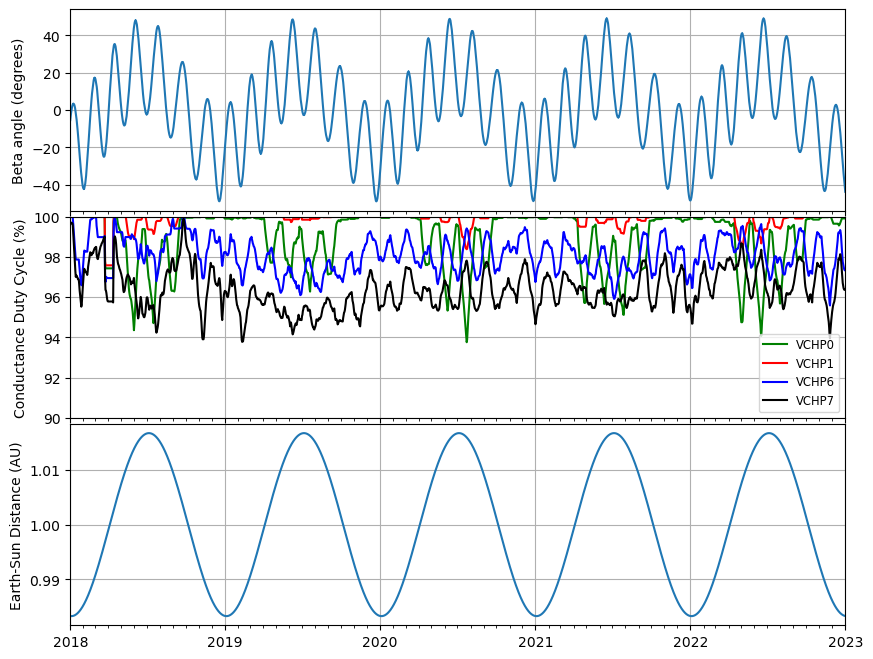

In [8]:
# 3 subplots for beta, VCHP, rAU, where the axes array is 1-d
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize = [10, 8])

# dntminShort="2018-01-01 00:00:00"
# dntmaxShort="2023-01-01 00:00:00"
dntmaxShort = dntmax
dnt0 = dt.datetime.strptime(dntminShort,"%Y-%m-%d %H:%M:%S")
dnt1 = dt.datetime.strptime(dntmaxShort,"%Y-%m-%d %H:%M:%S")

yrule = rrulewrapper(YEARLY, interval=1)
yloc = RRuleLocator(yrule)
mrule = rrulewrapper(MONTHLY, interval=1)
mloc = RRuleLocator(mrule)

ax3.xaxis.set_minor_locator(mloc)
ax1.plot(dnt, beta)
ax1.set_xlim(dnt0, dnt1)

ax1.grid(True)
ax1.set_ylabel('Beta angle (degrees)')

ax2.plot(fx,VCHP0*100,'-g',label='VCHP0')
ax2.plot(fx,VCHP1*100,'-r',label='VCHP1')
ax2.plot(fx,VCHP6*100,'-b',label='VCHP6')
ax2.plot(fx,VCHP7*100,'-k',label='VCHP7')
ax2.grid(True)
ax2.set_ylim(90,100)
ax3.xaxis.set_minor_locator(mloc)
ax2.legend(loc='lower right',fontsize='small')
ax2.set_ylabel('Conductance Duty Cycle (%)')

ax3.plot(dnt,rAU)
ax3.grid(True)
ax3.set_ylabel('Earth-Sun Distance (AU)')
ax3.xaxis.set_minor_locator(mloc)

fig.subplots_adjust(hspace=0.03)
plt.savefig(histShort)

Text(0, 0.5, 'Beta angle (deg)')

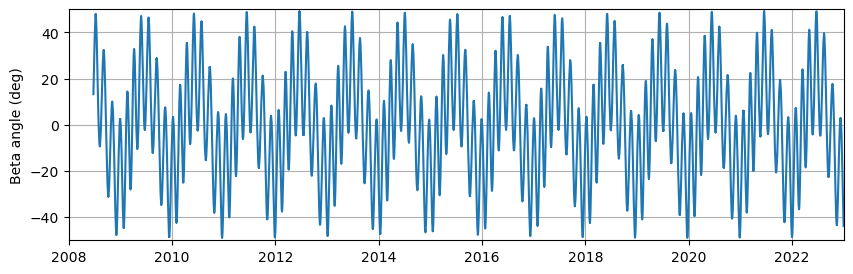

In [9]:
dnt0 = dt.datetime.strptime(dntmin,"%Y-%m-%d %H:%M:%S")
dnt1 = dt.datetime.strptime(dntmax,"%Y-%m-%d %H:%M:%S")

plt.figure(figsize = [10, 3])
plt.rc('font', size = 10)
plt.xlim(dnt0,dnt1)
plt.plot(dnt,beta)
plt.ylim([-50.0,50.0])
plt.grid(True)
plt.ylabel('Beta angle (deg)')

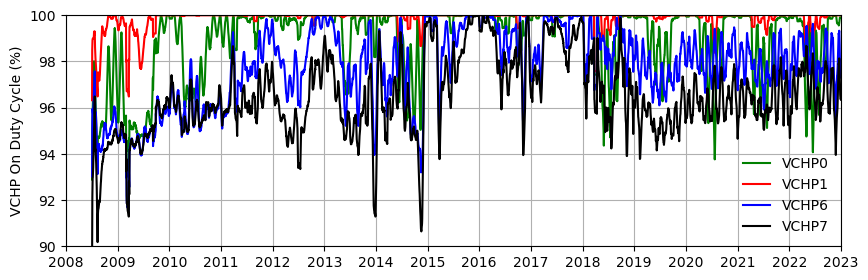

In [10]:
dnt0 = dt.datetime.strptime(dntmin,"%Y-%m-%d %H:%M:%S")
dnt1 = dt.datetime.strptime(dntmax,"%Y-%m-%d %H:%M:%S")

plt.rc('font', size = 10)
fig, ax = plt.subplots(figsize = [10, 3])
rule = rrulewrapper(YEARLY, interval=1)
loc = RRuleLocator(rule)
plt.xlim(dnt0,dnt1)
ax.xaxis.set_major_locator(loc)

plt.plot(fx,VCHP0*100,'-g',label='VCHP0')
plt.plot(fx,VCHP1*100,'-r',label='VCHP1')
plt.plot(fx,VCHP6*100,'-b',label='VCHP6')
plt.plot(fx,VCHP7*100,'-k',label='VCHP7')

plt.grid(True)
plt.ylim(90,100)
plt.ylabel('VCHP Conductance Duty Cycle')
plt.ylabel('VCHP On Duty Cycle (%)')
legend = ax.legend(loc='lower right', fontsize='medium', markerscale = 0,frameon = 0)

Text(0, 0.5, 'Earth-Sun Distance (AU)')

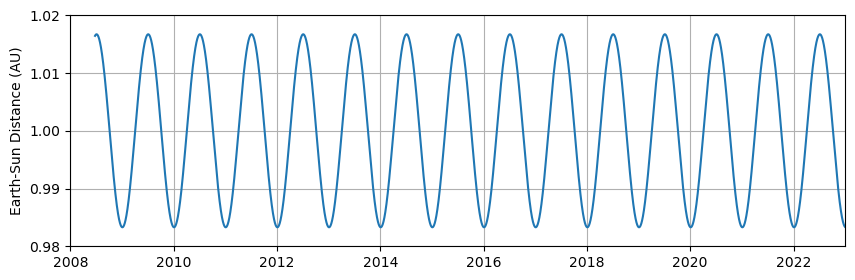

In [11]:
plt.figure(figsize = [10, 3])
plt.rc('font', size = 10)

dnt0 = dt.datetime.strptime(dntmin,"%Y-%m-%d %H:%M:%S")
dnt1 = dt.datetime.strptime(dntmax,"%Y-%m-%d %H:%M:%S")
plt.xlim(dnt0,dnt1)

plt.plot(dnt, rAU)
plt.grid(True)
plt.ylim(0.98, 1.02)
plt.ylabel('Earth-Sun Distance (AU)')

## VCHP Control History

In [12]:
fileroot = HOME

# Read ASCII file of history of LAT LTC VCHP control
# Use the file htr.history to create htr.scatter, which will be needed for the subsequent plot
if os.path.isfile(htrScatterFile):
   f = pd.read_csv(htrScatterFile, parse_dates=[1], delimiter=" ",header=None)
   print("Using file "+htrScatterFile)
else:
  print('The file htr.scatter was not found! Creating from htr.history...\n')
  if os.path.isfile(htrHistFile):
    with open(htrHistFile) as h:
      lines = h.readlines()
    out = open(htrScatterFile,"w+")
    for line in lines:
      line = line.split('\t')
      lineLength = len(line)
      LL3 = (lineLength - 1)/3
      date = line[0]
      hp = 0
      count = 0
      while (LL3 - hp) > 0:
        heater = str(line[1 + hp*3])
        # Don't divide by zero
        if (float(line[2 + hp*3]) != 0) and (float(line[3 + hp*3]) != 0):
          out.write(date+' HP_'+heater+' ''{0:.4f}'.format((float(line[3 + hp*3])/float(line[2 + hp*3])))+'\n')
          #out.write(output)
        hp += 1
    out.close()
    f = pd.read_csv(htrScatterFile, parse_dates=[1], delimiter=" ",header=None)
  else:
    print('The file htr.history was not found! File needed to continue!\n')

The file htr.scatter was not found! Creating from htr.history...



In [13]:
# Create the VCHP Control History plots with 1-sided error bars & non-arbitrary scaling

# create empty lists
dates = []
htr = []
val = []

# line-by-line read from history file
for line in open(htrHistFile):
    parts = line.strip().split('\t')
    d = parts[0]
    vchp_count = len(parts)//3 + 1
    for i in range(1,vchp_count):
        idx = (i-1)*3
        hp = int(parts[idx + 1])
        ct_max = int(parts[idx + 2])
        count = int(parts[idx + 3])
        if ct_max > 0 and count > 0:
            fraction = count/ct_max
            dates.append(d)
            htr.append(hp)
            val.append(fraction)
            
dates = pd.to_datetime(dates)
dates = pd.DataFrame(dates).squeeze()
htr = pd.DataFrame(htr).squeeze()
val = pd.DataFrame(val).squeeze()
val0 = val - val
vals = [val0, val]

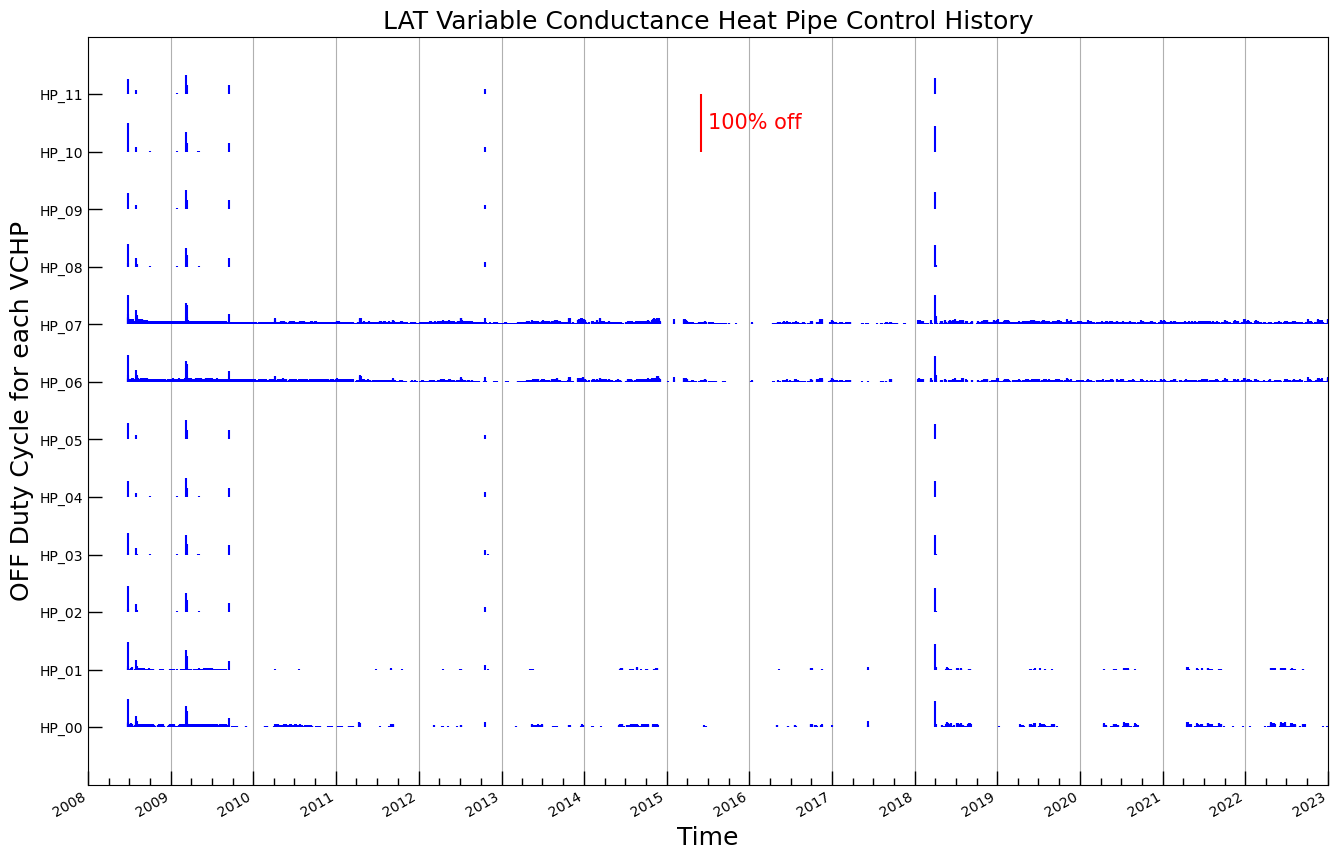

In [14]:
#plt.figure(figsize=(16,6))

fig, ax = plt.subplots(figsize = [16,11])

ax = plt.gca() # get the current axes

datemin = pd.to_datetime(dntmin.split()[0])
datemax = pd.to_datetime(dntmax.split()[0])
plt.xlim(datemin,datemax)
plt.ylim(-1,12)
ylabels = ('HP_00','HP_01','HP_02','HP_03','HP_04','HP_05','HP_06','HP_07','HP_08','HP_09','HP_10','HP_11')
plt.yticks(np.arange(12),ylabels)
plt.errorbar(dates, htr, yerr=vals, color='b',marker='',ls='none')
plt.title('LAT Variable Conductance Heat Pipe Control History',size=18)
plt.ylabel('OFF Duty Cycle for each VCHP',size=18)
plt.xlabel('Time',size=18)
#show 100% duty cycle scale in red
datehsc = ['2015-06-01']
datesc = [pd.to_datetime(d) for d in datehsc]
plt.errorbar(datesc,10.0,yerr=[[0],[1.0]],color='r',marker='',markersize=0.01,ls='none')
datehtxt = '2015-07-01'
datetxt = pd.to_datetime(datehtxt)
plt.text(datetxt, 10.4, '100% off', color = 'r',size=15)

yrule = rrulewrapper(YEARLY, interval=1)
yloc = RRuleLocator(yrule)
mrule = rrulewrapper(MONTHLY, interval=3)
mloc = RRuleLocator(mrule)
ax.xaxis.set_major_locator(yloc)
ax.xaxis.set_minor_locator(mloc)

xax = ax.get_xaxis() # get the x-axis
adf = xax.get_major_formatter() # the auto-formatter

adf.scaled[1./24] = '%H:%M'  # set the < 1day x-axis scale to H:M
adf.scaled[1.0] = '%Y-%m-%d' # set the > 1day < 1m x-axis scale to Y-m-d
adf.scaled[30.] = '%Y-%m' # set the > 1month < 1Y x-axis scale to Y-m
adf.scaled[365.] = '%Y' # set the > 1year x-axis scale to Y
ax.tick_params(which='major', length=10, width=1, direction='in')
ax.tick_params(which='minor', length=5, width=1, direction='in')
plt.grid(axis='x')
fig.autofmt_xdate()
plt.savefig(controlFull)

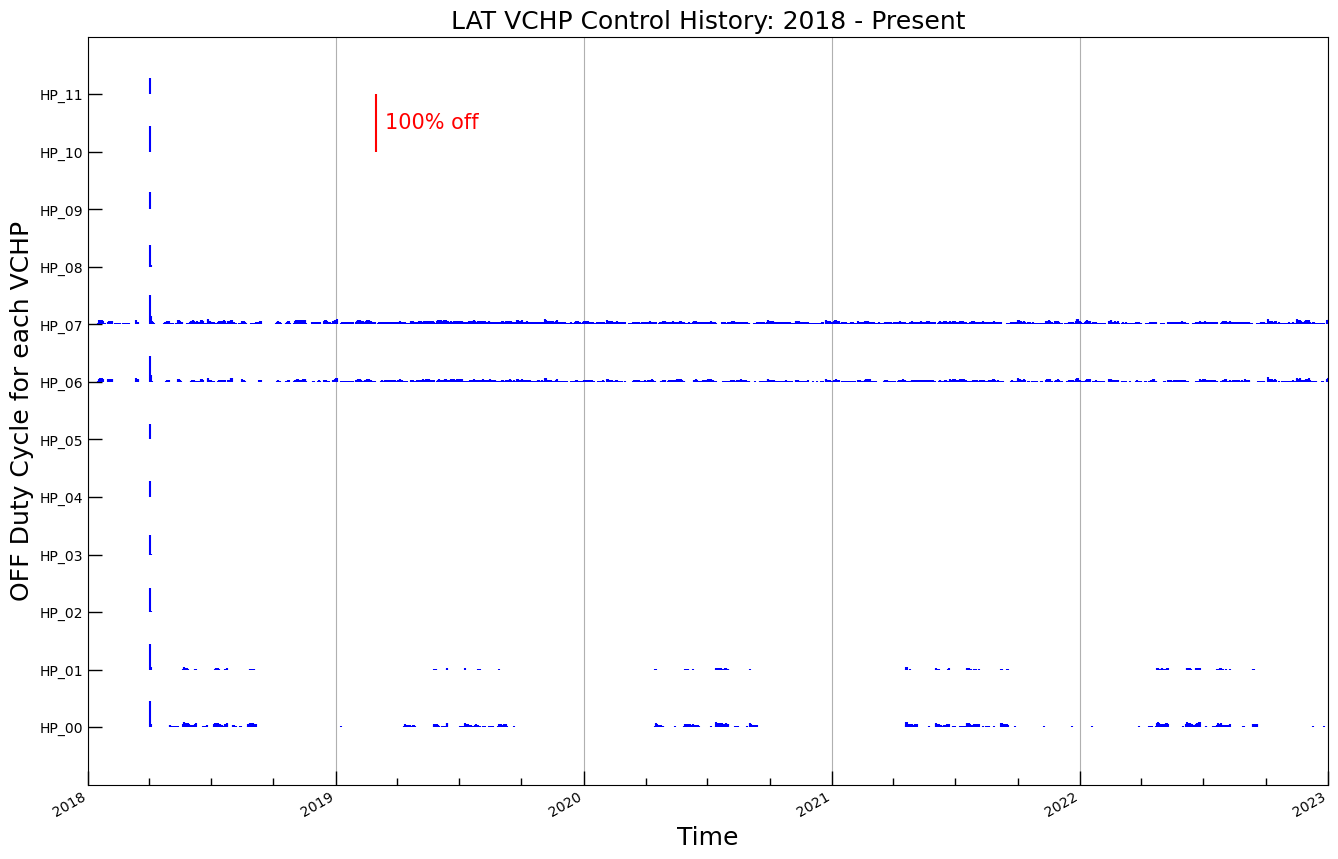

In [15]:
# make a zoomed-in plot

fig, ax = plt.subplots(figsize = [16,11])

ax = plt.gca() # get the current axes

datemin = pd.to_datetime(dntminShort.split()[0])
plt.xlim(datemin,datemax)
plt.ylim(-1,12)
#ylabels = ('HP_00','HP_01','HP_02','HP_03','HP_04','HP_05','HP_06','HP_07','HP_08','HP_09','HP_10','HP_11')
plt.yticks(np.arange(12),ylabels)
plt.errorbar(dates, htr, yerr=vals, color='b',marker='',ls='none')
plt.title('LAT VCHP Control History: 2018 - Present',size=18)
plt.ylabel('OFF Duty Cycle for each VCHP',size=18)
plt.xlabel('Time',size=18)
#show 100% duty cycle scale in red
datehsc = ['2019-03-01']
datesc = [pd.to_datetime(d) for d in datehsc]
plt.errorbar(datesc,10.0,yerr=[[0],[1.0]],color='r',marker='',markersize=0.01,ls='none')
datehtxt = '2019-03-15'
datetxt = pd.to_datetime(datehtxt)
plt.text(datetxt, 10.4, '100% off', color = 'r',size=15)

yrule = rrulewrapper(YEARLY, interval=1)
yloc = RRuleLocator(yrule)
mrule = rrulewrapper(MONTHLY, interval=3)
mloc = RRuleLocator(mrule)
ax.xaxis.set_major_locator(yloc)
ax.xaxis.set_minor_locator(mloc)

xax = ax.get_xaxis() # get the x-axis
adf = xax.get_major_formatter() # the auto-formatter

adf.scaled[1./24] = '%H:%M'  # set the < 1day x-axis scale to H:M
adf.scaled[1.0] = '%Y-%m-%d' # set the > 1day < 1m x-axis scale to Y-m-d
adf.scaled[30.] = '%Y-%m' # set the > 1month < 1Y x-axis scale to Y-m
adf.scaled[365.] = '%Y' # set the > 1year x-axis scale to Y
ax.tick_params(which='major', length=10, width=1, direction='in')
ax.tick_params(which='minor', length=5, width=1, direction='in')
plt.grid(axis='x')
fig.autofmt_xdate()
plt.savefig(controlShort)